In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

7196


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

dapi_image_file = os.path.join(data_folder, 'H0M1', 'Conv_zscan_001.dax')
#dapi_im = visual_tools.DaxReader(dapi_image_file).loadAll()[3::4][0::4]
#dapi_im = im[3::4]#[::4]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 161


In [5]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [10]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.884s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.988s.
-- corrected illumination for channel 488 in 8.040s.
-- corrected illumination for channel 405 in 7.735s.
- Finished illumination correction in 24.031s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

-- corrected illumination for channel 750 in 7.875s.
-- corrected illumination for channel 488 in 7.922s.
-- corrected illumination for channel 405 in 7.687s.
- Finished illumination correction in 23.735s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_004.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.031s.
-- corrected illumination for channel 488 in 2.031s.
- Finished illumination correction in 4.219s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -9.91  4.89] in 0.828s.
-- drift 1: [-0.

-- drift 0: [-0.04 -7.78  0.99] in 0.844s.
-- drift 1: [-0.05 -7.79  1.14] in 0.828s.
-- drift 2: [-0.05 -7.81  1.01] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -7.79333333  1.04666667] for channel: 750
-- finish warpping channel 750 in 22.000s.
488 False True
-- warp image with drift:[-0.04666667 -7.79333333  1.04666667] for channel: 488
-- finish warpping channel 488 in 22.094s.
-- finish warpping in 44.095s.
- apply microscope corrections
- run Cellpose segmentation in 55.891s.
(13, 2048, 2048) 7
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_7.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\C

- Loaded images for channels:['750', '488', '405'] in 5.656s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.750s.
-- corrected illumination for channel 488 in 7.891s.
-- corrected illumination for channel 405 in 7.938s.
- Finished illumination correction in 23.845s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_011.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.844s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.953s.
-- corrected illumination for channel 488 in 1.953s.
- Finished illumination correction in 4.234s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -8.7   0.24] in 0.850s.
-- drift 1: [-0.06 -8.58  0.36] in 0.837s.
-- drift 2: [-0.07 -8.67  0.28] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.06       -8.65        0.29333333] for channel: 750
-- finish warpping channel 750 in 22.157s.
488 False True
-- warp image with drift:[-0.06       -8.65        0.29333333] for channel: 488
-- finish warpping channel 488 in 22.703s.
-- finish warpping in 44.860s.
- apply microscope corrections
- run Cellpose segmentation in 58.094s.
(13, 2048, 2048) 14
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P

- run Cellpose segmentation in 55.642s.
(13, 2048, 2048) 17
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_17.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_018.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_018.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_018.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.406s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.739s.
-- corrected illumination f

-- corrected illumination for channel 750 in 7.750s.
-- corrected illumination for channel 488 in 7.812s.
-- corrected illumination for channel 405 in 7.672s.
- Finished illumination correction in 23.454s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_021.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.516s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.045s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.218s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -9.41 -2.51] in 0.844s.
-- drift 1: [-0.

-- drift 0: [-0.02 -8.99 -2.46] in 0.844s.
-- drift 1: [ 0.   -9.17 -2.5 ] in 0.828s.
-- drift 2: [-0.02 -9.19 -2.45] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333 -9.11666667 -2.47      ] for channel: 750
-- finish warpping channel 750 in 22.125s.
488 False True
-- warp image with drift:[-0.01333333 -9.11666667 -2.47      ] for channel: 488
-- finish warpping channel 488 in 22.157s.
-- finish warpping in 44.282s.
- apply microscope corrections
- run Cellpose segmentation in 56.751s.
(13, 2048, 2048) 24
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_24.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_025.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_025.dax
Initialize DaxProcesser for file:\\10.245.74.158

- Loaded images for channels:['750', '488', '405'] in 3.359s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.905s.
-- corrected illumination for channel 488 in 7.923s.
-- corrected illumination for channel 405 in 7.875s.
- Finished illumination correction in 23.954s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_028.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.969s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

-- corrected illumination for channel 750 in 2.041s.
-- corrected illumination for channel 488 in 2.034s.
- Finished illumination correction in 4.251s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -7.46  1.03] in 0.843s.
-- drift 1: [ 0.   -7.31  1.53] in 0.859s.
-- drift 2: [ 0.05 -7.32  1.39] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -7.36333333  1.31666667] for channel: 750
-- finish warpping channel 750 in 22.047s.
488 False True
-- warp image with drift:[ 0.01       -7.36333333  1.31666667] for channel: 488
-- finish warpping channel 488 in 22.267s.
-- finish warpping in 44.314s.
- apply microscope corrections
- run Cellpose segmentation in 52.531s.
(13, 2048, 2048) 31
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segment

- run Cellpose segmentation in 53.063s.
(13, 2048, 2048) 34
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_34.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_035.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_035.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_035.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 4.734s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.563s.
-- corrected illumination f

-- corrected illumination for channel 750 in 7.578s.
-- corrected illumination for channel 488 in 7.703s.
-- corrected illumination for channel 405 in 7.626s.
- Finished illumination correction in 23.141s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_038.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.172s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.938s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.063s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.1  -8.68  5.27] in 0.876s.
-- drift 1: [-0.

-- drift 0: [ -3.61 121.46 145.25] in 0.859s.
-- drift 1: [ 0.1  -8.64  2.87] in 0.859s.
-- drift 2: [ 0.06 -9.86  3.19] in 0.812s.
-- drift 3: [ 0.06 -8.7   2.91] in 0.844s.
-- drift 4: [ 0.05 -8.75  2.88] in 0.844s.
-- drift 5: [ 0.07 -8.53  2.96] in 0.844s.
-- drift 6: [ 0.11 -8.75  3.1 ] in 0.859s.
-- drift 7: [ 0.05 -8.77  2.91] in 0.828s.
-- return a sub-optimal drift
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.05333333 -8.74        2.9       ] for channel: 750
-- finish warpping channel 750 in 21.594s.
488 False True
-- warp image with drift:[ 0.05333333 -8.74        2.9       ] for channel: 488
-- finish warpping channel 488 in 22.032s.
-- finish warpping in 43.626s.
- apply microscope corrections
- run Cellpose segmentation in 56.844s.
(13, 2048, 2048) 41
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_41.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M

- run Cellpose segmentation in 55.251s.
(13, 2048, 2048) 44
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_44.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_045.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_045.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_045.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.500s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.625s.
-- corrected illumination f

-- corrected illumination for channel 750 in 7.547s.
-- corrected illumination for channel 488 in 7.938s.
-- corrected illumination for channel 405 in 7.922s.
- Finished illumination correction in 23.625s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_048.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.844s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.952s.
-- corrected illumination for channel 488 in 1.969s.
- Finished illumination correction in 4.062s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -8.5   4.56] in 0.859s.
-- drift 1: [ 0.

-- corrected illumination for channel 488 in 1.970s.
- Finished illumination correction in 4.281s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -7.77  7.27] in 0.859s.
-- drift 1: [-0.04 -7.87  7.5 ] in 0.828s.
-- drift 2: [-0.05 -7.7   7.29] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -7.78        7.35333333] for channel: 750
-- finish warpping channel 750 in 21.688s.
488 False True
-- warp image with drift:[-0.04666667 -7.78        7.35333333] for channel: 488
-- finish warpping channel 488 in 21.891s.
-- finish warpping in 43.579s.
- apply microscope corrections
- run Cellpose segmentation in 55.516s.
(13, 2048, 2048) 51
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_51.npy
\\10.245.74.158\Chromatin_NAS_0\20

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_055.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_055.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_055.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.750s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.656s.
-- corrected illumination for channel 488 in 8.094s.
-- corrected illumination for channel 405 in 7.938s.
- Finished illumination correction in 23.938s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

- Loaded images for channels:['750', '488'] in 1.766s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.000s.
-- corrected illumination for channel 488 in 2.000s.
- Finished illumination correction in 4.268s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.11 -9.05  4.52] in 0.828s.
-- drift 1: [-0.11 -8.82  4.76] in 0.844s.
-- drift 2: [-0.13 -8.84  4.59] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.11666667 -8.90333333  4.62333333] for channel: 750
-- finish warpping channel 750 in 21.688s.
488 False True
-- warp image with drift:[-0.11666667 -8.90333333  4.62333333] for channel: 488
-- fi

-- warp image with drift:[-0.05333333 -9.00666667  6.78      ] for channel: 750
-- finish warpping channel 750 in 22.266s.
488 False True
-- warp image with drift:[-0.05333333 -9.00666667  6.78      ] for channel: 488
-- finish warpping channel 488 in 22.063s.
-- finish warpping in 44.328s.
- apply microscope corrections
- run Cellpose segmentation in 56.081s.
(13, 2048, 2048) 61
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_61.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_062.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.690s.
- Start illumination co

- Loaded images for channels:['750', '488', '405'] in 3.531s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.496s.
-- corrected illumination for channel 488 in 7.625s.
-- corrected illumination for channel 405 in 7.813s.
- Finished illumination correction in 23.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_065.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.797s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

-- corrected illumination for channel 750 in 2.063s.
-- corrected illumination for channel 488 in 2.047s.
- Finished illumination correction in 4.265s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -8.78  4.23] in 0.875s.
-- drift 1: [-0.06 -8.88  4.39] in 0.844s.
-- drift 2: [-0.06 -8.73  4.27] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.05666667 -8.79666667  4.29666667] for channel: 750
-- finish warpping channel 750 in 21.766s.
488 False True
-- warp image with drift:[-0.05666667 -8.79666667  4.29666667] for channel: 488
-- finish warpping channel 488 in 22.391s.
-- finish warpping in 44.157s.
- apply microscope corrections
- run Cellpose segmentation in 56.485s.
(13, 2048, 2048) 68
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segment

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_072.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_072.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.109s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.484s.
-- corrected illumination for channel 488 in 7.860s.
-- corrected illumination for channel 405 in 7.922s.
- Finished illumination correction in 23.485s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

- Loaded images for channels:['750', '488'] in 1.750s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.093s.
-- corrected illumination for channel 488 in 2.031s.
- Finished illumination correction in 4.406s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -9.44 11.55] in 0.848s.
-- drift 1: [-0.06 -9.36 11.51] in 0.853s.
-- drift 2: [-0.03 -8.71 11.53] in 0.829s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -9.17       11.53      ] for channel: 750
-- finish warpping channel 750 in 22.188s.
488 False True
-- warp image with drift:[-0.04666667 -9.17       11.53      ] for channel: 488
-- fi

-- warp image with drift:[-0.29       -8.82333333  2.82      ] for channel: 488
-- finish warpping channel 488 in 23.518s.
-- finish warpping in 46.266s.
- apply microscope corrections
- run Cellpose segmentation in 68.489s.
(13, 2048, 2048) 78
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_78.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_079.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.827s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.891s.
-- corrected illumination for channel 488 in 8.016s.
-- corrected illumination for channel 405 in 7.875s.
- Finished illumination correction in 24.063s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_082.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.109s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.985s.
-- corrected illumination for channel 488 in 2.000s.
- Finished illumination correction in 4.141s.
+ Calculate drift with drift_channel: 488
-- start aligning given so

-- drift 0: [-0.06 -7.85  4.06] in 0.891s.
-- drift 1: [-0.05 -7.78  4.25] in 0.849s.
-- drift 2: [-0.08 -7.61  3.95] in 0.838s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.06333333 -7.74666667  4.08666667] for channel: 750
-- finish warpping channel 750 in 22.113s.
488 False True
-- warp image with drift:[-0.06333333 -7.74666667  4.08666667] for channel: 488
-- finish warpping channel 488 in 22.361s.
-- finish warpping in 44.474s.
- apply microscope corrections
- run Cellpose segmentation in 56.016s.
(13, 2048, 2048) 85
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_85.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_086.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_086.dax
Initialize DaxProcesser for file:\\10.245.74.158

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_089.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_089.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_089.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.966s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.815s.
-- corrected illumination for channel 488 in 7.984s.
-- corrected illumination for channel 405 in 7.813s.
- Finished illumination correction in 23.896s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

- Loaded images for channels:['750', '488'] in 0.893s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.985s.
-- corrected illumination for channel 488 in 2.047s.
- Finished illumination correction in 4.234s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.1  -9.2   5.04] in 0.828s.
-- drift 1: [-0.12 -8.93  5.39] in 0.884s.
-- drift 2: [-0.16 -8.92  5.44] in 0.834s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.12666667 -9.01666667  5.29      ] for channel: 750
-- finish warpping channel 750 in 22.235s.
488 False True
-- warp image with drift:[-0.12666667 -9.01666667  5.29      ] for channel: 488
-- fi

-- finish warpping channel 750 in 22.204s.
488 False True
-- warp image with drift:[-0.05 -6.16  1.89] for channel: 488
-- finish warpping channel 488 in 22.311s.
-- finish warpping in 44.515s.
- apply microscope corrections
- run Cellpose segmentation in 56.016s.
(13, 2048, 2048) 95
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_95.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_096.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_096.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_096.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 4.033s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.938s.
-- corrected illumination for channel 488 in 7.938s.
-- corrected illumination for channel 405 in 7.797s.
- Finished illumination correction in 23.922s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.156s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.034s.
-- corrected illumination for channel 488 in 2.060s.
- Finished illumination correction in 4.329s.
+ Calculate drift with drift_channel: 488
-- start aligning given so

-- corrected illumination for channel 750 in 1.969s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.109s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -7.37  5.35] in 0.828s.
-- drift 1: [-0.03 -7.28  5.5 ] in 0.828s.
-- drift 2: [-0.03 -7.24  5.45] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03       -7.29666667  5.43333333] for channel: 750
-- finish warpping channel 750 in 21.813s.
488 False True
-- warp image with drift:[-0.03       -7.29666667  5.43333333] for channel: 488
-- finish warpping channel 488 in 22.249s.
-- finish warpping in 44.062s.
- apply microscope corrections
- run Cellpose segmentation in 55.983s.
(13, 2048, 2048) 102
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmen

- run Cellpose segmentation in 55.219s.
(13, 2048, 2048) 105
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_105.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_106.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.438s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.733s.
-- corrected illumination

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 8.219s.
-- corrected illumination for channel 488 in 8.156s.
-- corrected illumination for channel 405 in 7.875s.
- Finished illumination correction in 24.469s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.938s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.969s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.078s.
+ Calculate drift with drift_channel: 488
-- start aligning given so

-- drift 0: [-0.05 -7.49  6.11] in 0.860s.
-- drift 1: [-0.04 -7.37  6.29] in 0.843s.
-- drift 2: [-0.05 -7.38  6.14] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -7.41333333  6.18      ] for channel: 750
-- finish warpping channel 750 in 21.969s.
488 False True
-- warp image with drift:[-0.04666667 -7.41333333  6.18      ] for channel: 488
-- finish warpping channel 488 in 22.125s.
-- finish warpping in 44.094s.
- apply microscope corrections
- run Cellpose segmentation in 56.828s.
(13, 2048, 2048) 112
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_112.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_113.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_113.dax
Initialize DaxProcesser for file:\\10.245.74.1

- Loaded images for channels:['750', '488', '405'] in 3.328s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.375s.
-- corrected illumination for channel 488 in 7.438s.
-- corrected illumination for channel 405 in 7.641s.
- Finished illumination correction in 22.672s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.766s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

-- corrected illumination for channel 750 in 1.953s.
-- corrected illumination for channel 488 in 1.969s.
- Finished illumination correction in 4.078s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.12 -6.29  8.27] in 0.845s.
-- drift 1: [-0.09 -6.12  8.39] in 0.824s.
-- drift 2: [-0.13 -6.08  8.23] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.11333333 -6.16333333  8.29666667] for channel: 750
-- finish warpping channel 750 in 21.703s.
488 False True
-- warp image with drift:[-0.11333333 -6.16333333  8.29666667] for channel: 488
-- finish warpping channel 488 in 22.204s.
-- finish warpping in 43.907s.
- apply microscope corrections
- run Cellpose segmentation in 54.884s.
(13, 2048, 2048) 119
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmen

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_123.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_123.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.500s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.625s.
-- corrected illumination for channel 488 in 7.781s.
-- corrected illumination for channel 405 in 7.875s.
- Finished illumination correction in 23.547s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

- Loaded images for channels:['750', '488'] in 0.812s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.969s.
-- corrected illumination for channel 488 in 1.953s.
- Finished illumination correction in 4.075s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.08 -4.62  3.42] in 0.844s.
-- drift 1: [-0.07 -4.26  3.11] in 0.844s.
-- drift 2: [-0.09 -4.25  2.91] in 0.841s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.08       -4.37666667  3.14666667] for channel: 750
-- finish warpping channel 750 in 21.800s.
488 False True
-- warp image with drift:[-0.08       -4.37666667  3.14666667] for channel: 488
-- fi

-- warp image with drift:[-0.04333333 -5.91666667  8.20666667] for channel: 488
-- finish warpping channel 488 in 22.266s.
-- finish warpping in 43.985s.
- apply microscope corrections
- run Cellpose segmentation in 56.407s.
(13, 2048, 2048) 129
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_129.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_130.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_130.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 5.281s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_204

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.516s.
-- corrected illumination for channel 488 in 7.688s.
-- corrected illumination for channel 405 in 7.985s.
- Finished illumination correction in 23.407s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_133.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.922s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.991s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.156s.
+ Calculate drift with drift_channel: 488
-- start aligning given so

-- drift 0: [-0.08 -7.03 12.18] in 0.859s.
-- drift 1: [-0.08 -6.91 12.17] in 0.844s.
-- drift 2: [-0.09 -6.94 12.08] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.08333333 -6.96       12.14333333] for channel: 750
-- finish warpping channel 750 in 21.875s.
488 False True
-- warp image with drift:[-0.08333333 -6.96       12.14333333] for channel: 488
-- finish warpping channel 488 in 22.078s.
-- finish warpping in 43.953s.
- apply microscope corrections
- run Cellpose segmentation in 55.421s.
(13, 2048, 2048) 136
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_136.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_137.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_137.dax
Initialize DaxProcesser for file:\\10.245.74.1

- Loaded images for channels:['750', '488', '405'] in 3.594s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.610s.
-- corrected illumination for channel 488 in 7.734s.
-- corrected illumination for channel 405 in 7.750s.
- Finished illumination correction in 23.328s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_140.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.766s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.953s.
-- corrected illumination for channel 488 in 1.984s.
- Finished illumination correction in 4.266s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -6.56  4.74] in 0.859s.
-- drift 1: [-0.02 -6.6   4.78] in 0.844s.
-- drift 2: [-0.03 -6.38  4.9 ] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02333333 -6.51333333  4.80666667] for channel: 750
-- finish warpping channel 750 in 21.891s.
488 False True
-- warp image with drift:[-0.02333333 -6.51333333  4.80666667] for channel: 488
-- finish warpping channel 488 in 22.047s.
-- finish warpping in 43.938s.
- apply microscope corrections
- run Cellpose segmentation in 55.172s.
(13, 2048, 2048) 143
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-

- run Cellpose segmentation in 57.884s.
(13, 2048, 2048) 146
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_146.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_147.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_147.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_147.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 4.113s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.936s.
-- corrected illumination

-- corrected illumination for channel 750 in 7.461s.
-- corrected illumination for channel 488 in 7.879s.
-- corrected illumination for channel 405 in 7.957s.
- Finished illumination correction in 23.553s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_150.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.919s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.955s.
-- corrected illumination for channel 488 in 1.980s.
- Finished illumination correction in 4.095s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -6.5   9.19] in 0.847s.
-- drift 1: [ 0.

-- drift 0: [-0.06 -5.97  8.99] in 0.856s.
-- drift 1: [-0.05 -5.89  9.05] in 0.836s.
-- drift 2: [-0.1  -5.8   8.33] in 0.869s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.07       -5.88666667  8.79      ] for channel: 750
-- finish warpping channel 750 in 22.183s.
488 False True
-- warp image with drift:[-0.07       -5.88666667  8.79      ] for channel: 488
-- finish warpping channel 488 in 22.754s.
-- finish warpping in 44.938s.
- apply microscope corrections
- run Cellpose segmentation in 56.737s.
(13, 2048, 2048) 153
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_153.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_154.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_154.dax
Initialize DaxProcesser for file:\\10.245.74.1

- Loaded images for channels:['750', '488', '405'] in 4.046s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.595s.
-- corrected illumination for channel 488 in 7.931s.
-- corrected illumination for channel 405 in 7.903s.
- Finished illumination correction in 23.683s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_157.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.830s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.025s.
-- corrected illumination for channel 488 in 2.054s.
- Finished illumination correction in 4.424s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 3.000e-02 -5.750e+00 -3.467e+01] in 0.878s.
-- drift 1: [  0.23  -5.44 -34.45] in 0.880s.
-- drift 2: [ 3.000e-02 -5.700e+00 -3.461e+01] in 0.846s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.09666667  -5.63       -34.57666667] for channel: 750
-- finish warpping channel 750 in 22.297s.
488 False True
-- warp image with drift:[  0.09666667  -5.63       -34.57666667] for channel: 488
-- finish warpping channel 488 in 22.242s.
-- finish warpping in 44.539s.
- apply microscope corrections
- run Cellpose segmentation in 55.523s.
(13, 2048, 2048) 160
- save to file: \\

## Check result

<IPython.core.display.Javascript object>


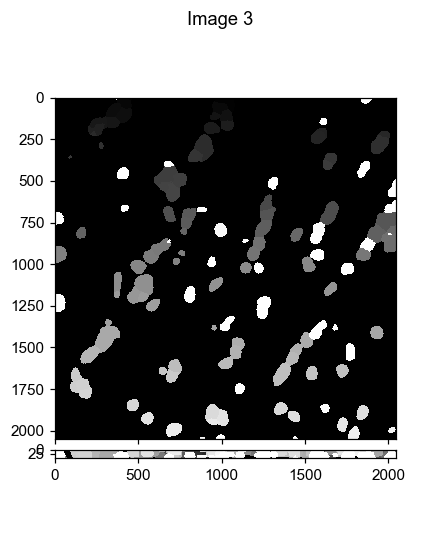

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])